In [ ]:
#CIFAR-10 MixUp vs CutMix with AdamW

#configs, utils, model, MixUp/CutMix
import os, csv, random, numpy as np, torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18

#configs
def _merge(a, b):
    out = dict(a)
    for k, v in b.items():
        if isinstance(v, dict) and isinstance(out.get(k), dict):
            out[k] = _merge(out[k], v)
        else:
            out[k] = v
    return out

BASE = {
    "seed": 42,
    "epochs": 100,
    "batch_size": 128,
    "num_workers": 2,  #set to 2 to avoid worker warning
    "amp": True,
    "label_smoothing": 0.0,
    "optimizer": {"name": "adamw", "lr": 5e-4, "weight_decay": 0.02, "betas": (0.9, 0.999), "eps": 1e-8},
    "scheduler": {"warmup_epochs": 5},
    "model": {"name": "resnet18_cifar"},
    "data": {
        "root": "./data",
        "mean": (0.4914, 0.4822, 0.4465),
        "std":  (0.2470, 0.2435, 0.2616),
    },
    "augment_mode": "off",
    "mixup_alpha": 0.0,
    "cutmix_alpha": 0.0,
    "save_dir": "results/run",
}
MIXUP  = {"augment_mode": "mixup",  "mixup_alpha": 0.4, "save_dir": "results/mixup"}
CUTMIX = {"augment_mode": "cutmix", "cutmix_alpha": 1.0, "save_dir": "results/cutmix"}

PROFILES = {"base": BASE, "mixup": _merge(BASE, MIXUP), "cutmix": _merge(BASE, CUTMIX)}

def get_config(profile: str, overrides: dict | None = None):
    if profile not in PROFILES:
        raise ValueError(f"unknown profile: {profile}")
    cfg = dict(PROFILES[profile])
    if overrides:
        cfg = _merge(cfg, overrides)
    return cfg

#io and reproducibility
def ensure_dir(d): os.makedirs(d, exist_ok=True)
def save_ckpt(state, path): torch.save(state, path)
def csv_logger(path):
    f = open(path, "w", newline="")
    w = csv.DictWriter(f, fieldnames=["epoch","train_loss","val_loss","val_acc"])
    w.writeheader()
    return f, w

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#optimizer and scheduler
def build_optimizer(model, cfg):
    opt = cfg["optimizer"]
    if opt["name"].lower() != "adamw":
        raise ValueError("This setup uses AdamW for both MixUp and CutMix.")
    return AdamW(model.parameters(), lr=opt["lr"], weight_decay=opt["weight_decay"],
                 betas=opt.get("betas", (0.9,0.999)), eps=opt.get("eps", 1e-8))

def build_warmup_cosine(optimizer, steps_per_epoch: int, epochs: int, warmup_epochs: int):
    warmup_iters = max(1, warmup_epochs * steps_per_epoch)
    total_iters  = max(1, epochs * steps_per_epoch)
    cosine_iters = max(1, total_iters - warmup_iters)
    warmup = LinearLR(optimizer, start_factor=1e-3, end_factor=1.0, total_iters=warmup_iters)
    cosine = CosineAnnealingLR(optimizer, T_max=cosine_iters)
    return SequentialLR(optimizer, [warmup, cosine], milestones=[warmup_iters])

#model
def build_model(name: str, num_classes=10):
    if name != "resnet18_cifar":
        raise ValueError(f"unsupported model: {name}")
    m = resnet18(weights=None, num_classes=num_classes)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    return m

#MixUp / CutMix
def mixup_data(x, y, alpha: float):
    lam = torch.distributions.Beta(alpha, alpha).sample().item() if alpha and alpha > 0 else 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    return lam * x + (1 - lam) * x[idx], y, y[idx], lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def _rand_bbox(W, H, lam):
    r = (1 - lam) ** 0.5
    cw, ch = int(W*r), int(H*r)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = np.clip(cx - cw//2, 0, W), np.clip(cy - ch//2, 0, H)
    x2, y2 = np.clip(cx + cw//2, 0, W), np.clip(cy + ch//2, 0, H)
    return x1, y1, x2, y2

def cutmix_data(x, y, alpha: float):
    lam = torch.distributions.Beta(alpha, alpha).sample().item() if alpha and alpha > 0 else 1.0
    bs, _, H, W = x.size()
    idx = torch.randperm(bs, device=x.device)
    x1, y1, x2, y2 = _rand_bbox(W, H, lam)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1)) / (W * H)  # exact area ratio
    return x, y, y[idx], lam



In [ ]:
# CIFAR10 MixUp vs CutMix + AdamW
# Wire everything together: data, model, optimizer/scheduler, augmentation, AMP, training loop, validation, and logging.
# Per-iteration stepping keeps LR in sync with updates; AMP speeds up on modern GPUs with low complexity.

import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm
from contextlib import nullcontext

# AMP shim
def make_scaler(enabled: bool):
    if torch.cuda.is_available():
        return torch.cuda.amp.GradScaler(enabled=enabled)
    # CPU: no-op scaler with same API
    class _Dummy:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    return _Dummy()

def amp_autocast(enabled: bool):
    if torch.cuda.is_available():
        return torch.cuda.amp.autocast(enabled=enabled)
    return nullcontext()

#args
def parse_args(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--profile", choices=["base","mixup","cutmix"],
                    default=os.environ.get("PROFILE","mixup"),
                    help="experiment profile; default='mixup' (override with PROFILE env var)")
    ap.add_argument("--save_dir", type=str, default=None)
    ap.add_argument("--epochs", type=int, default=None)
    ap.add_argument("--batch_size", type=int, default=None)
    ap.add_argument("--lr", type=float, default=None)
    ap.add_argument("--weight_decay", type=float, default=None)
    ap.add_argument("--mixup_alpha", type=float, default=None)
    ap.add_argument("--cutmix_alpha", type=float, default=None)
    if argv is None:  # ignore IPython/Colab argv in notebooks
        argv = []
    return ap.parse_args(argv)

#transforms
def build_transforms(mean, std):
    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
    return train_tfms, test_tfms

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total = correct = 0
    loss_sum = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += F.cross_entropy(logits, y).item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

#train one epoch (warmup)
def train_one_epoch(model, loader, optimizer, scaler, device, criterion,
                    scheduler, augment_mode, mixup_alpha, cutmix_alpha, use_amp):
    model.train()
    total = 0
    loss_sum = 0.0
    for x, y in tqdm(loader, leave=False, desc="train"):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        if augment_mode == "mixup":
            x, ya, yb, lam = mixup_data(x, y, mixup_alpha)
            loss_fn = lambda logits: mixup_criterion(criterion, logits, ya, yb, lam)
        elif augment_mode == "cutmix":
            x, ya, yb, lam = cutmix_data(x, y, cutmix_alpha)
            loss_fn = lambda logits: mixup_criterion(criterion, logits, ya, yb, lam)
        else:
            loss_fn = lambda logits: criterion(logits, y)

        optimizer.zero_grad(set_to_none=True)
        #AMP
        with amp_autocast(enabled=use_amp):
            logits = model(x)
            loss = loss_fn(logits)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            scheduler.step()

        bs = y.size(0)
        total += bs
        loss_sum += loss.item() * bs
    return loss_sum / total

#main
def main():
    args = parse_args()

    overrides = {}
    if args.save_dir is not None: overrides["save_dir"] = args.save_dir
    if args.epochs is not None: overrides["epochs"] = args.epochs
    if args.batch_size is not None: overrides["batch_size"] = args.batch_size
    if args.lr is not None: overrides.setdefault("optimizer", {})["lr"] = args.lr
    if args.weight_decay is not None: overrides.setdefault("optimizer", {})["weight_decay"] = args.weight_decay
    if args.mixup_alpha is not None: overrides["mixup_alpha"] = args.mixup_alpha
    if args.cutmix_alpha is not None: overrides["cutmix_alpha"] = args.cutmix_alpha

    cfg = get_config(args.profile, overrides)
    set_seed(cfg["seed"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ensure_dir(cfg["save_dir"])
    ckpt_dir = os.path.join(cfg["save_dir"], "ckpts")
    ensure_dir(ckpt_dir)
    log_f, writer = csv_logger(os.path.join(cfg["save_dir"], "metrics.csv"))

    mean, std = cfg["data"]["mean"], cfg["data"]["std"]
    train_tfms, test_tfms = build_transforms(mean, std)

    #CIFAR-10
    train_set = torchvision.datasets.CIFAR10(root=cfg["data"]["root"], train=True,  download=True, transform=train_tfms)
    test_set  = torchvision.datasets.CIFAR10(root=cfg["data"]["root"], train=False, download=True, transform=test_tfms)

    train_loader = DataLoader(train_set, batch_size=cfg["batch_size"], shuffle=True,
                              num_workers=cfg["num_workers"], pin_memory=True, drop_last=True)
    test_loader  = DataLoader(test_set,  batch_size=cfg["batch_size"], shuffle=False,
                              num_workers=cfg["num_workers"], pin_memory=True)

    #model, opt, loss, AMP, scheduler
    model = build_model(cfg["model"]["name"], num_classes=10).to(device)
    optimizer = build_optimizer(model, cfg)
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.get("label_smoothing", 0.0))
    scaler = make_scaler(enabled=cfg["amp"])  #AMP shim

    steps_per_epoch = len(train_loader)
    scheduler = build_warmup_cosine(optimizer, steps_per_epoch, cfg["epochs"], cfg["scheduler"]["warmup_epochs"])

    augment_mode = cfg.get("augment_mode", "off")
    mixup_alpha  = cfg.get("mixup_alpha", 0.0)
    cutmix_alpha = cfg.get("cutmix_alpha", 0.0)

    print(f"[cfg] profile={args.profile} | augment_mode={augment_mode} | mixup_alpha={mixup_alpha} | cutmix_alpha={cutmix_alpha} | save_dir={cfg['save_dir']}")

    best_acc = 0.0
    try:
        for epoch in range(cfg["epochs"]):
            tr_loss = train_one_epoch(model, train_loader, optimizer, scaler, device, criterion, scheduler,
                                      augment_mode, mixup_alpha, cutmix_alpha, cfg["amp"])
            va_loss, va_acc = evaluate(model, test_loader, device)
            writer.writerow({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss, "val_acc": va_acc})
            if va_acc > best_acc:
                best_acc = va_acc
                save_ckpt({"epoch": epoch, "model": model.state_dict(), "best_acc": best_acc},
                          os.path.join(ckpt_dir, "best.pth"))
            print(f"epoch {epoch+1}/{cfg['epochs']} | train {tr_loss:.4f} | val {va_loss:.4f} | acc {va_acc*100:.2f}%")
    finally:
        log_f.close()

#Running MixUp, then CutMix
if __name__ == "__main__":
    #MixUp
    os.environ["PROFILE"] = "mixup"
    print("MIXUP RUN")
    main()

    #CutMix
    os.environ["PROFILE"] = "cutmix"
    print("CUTMIX RUN")
    main()


MIXUP RUN


100%|██████████| 170M/170M [00:17<00:00, 9.81MB/s]
/tmp/ipython-input-3855406967.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler(enabled=enabled)


[cfg] profile=mixup | augment_mode=mixup | mixup_alpha=0.4 | cutmix_alpha=0.0 | save_dir=results/mixup


train:   0%|          | 0/390 [00:00<?, ?it/s]/tmp/ipython-input-3855406967.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast(enabled=enabled)


epoch 1/100 | train 1.9405 | val 1.4524 | acc 46.06%


epoch 2/100 | train 1.6243 | val 1.2615 | acc 55.15%


epoch 3/100 | train 1.4193 | val 0.9892 | acc 65.87%


epoch 4/100 | train 1.2998 | val 1.0434 | acc 63.89%


epoch 5/100 | train 1.2270 | val 0.7884 | acc 73.73%


epoch 6/100 | train 1.1410 | val 0.6747 | acc 79.49%


epoch 7/100 | train 1.1197 | val 0.6702 | acc 79.07%


epoch 8/100 | train 1.0837 | val 0.6793 | acc 79.17%


epoch 9/100 | train 1.0300 | val 0.6109 | acc 81.37%


epoch 10/100 | train 0.9683 | val 0.5748 | acc 84.99%


epoch 11/100 | train 0.9668 | val 0.6060 | acc 83.08%


epoch 12/100 | train 0.9557 | val 0.5737 | acc 84.45%


epoch 13/100 | train 0.9087 | val 0.5867 | acc 80.87%


epoch 14/100 | train 0.9232 | val 0.5017 | acc 85.14%


epoch 15/100 | train 0.8755 | val 0.5356 | acc 85.30%


epoch 16/100 | train 0.8161 | val 0.4762 | acc 86.44%


epoch 17/100 | train 0.8524 | val 0.4699 | acc 87.53%


epoch 18/100 | train 0.8461 | val 0.4760 | acc 87.08%


epoch 19/100 | train 0.8555 | val 0.4987 | acc 86.63%


epoch 20/100 | train 0.7810 | val 0.4662 | acc 87.26%


epoch 21/100 | train 0.7755 | val 0.4202 | acc 88.82%


epoch 22/100 | train 0.7773 | val 0.4101 | acc 89.20%


epoch 23/100 | train 0.7848 | val 0.3619 | acc 90.10%


epoch 24/100 | train 0.7889 | val 0.3784 | acc 90.27%


epoch 25/100 | train 0.7927 | val 0.4340 | acc 89.60%


epoch 26/100 | train 0.7289 | val 0.4659 | acc 88.76%


epoch 27/100 | train 0.7781 | val 0.3618 | acc 90.73%


epoch 28/100 | train 0.7595 | val 0.4116 | acc 90.86%


epoch 29/100 | train 0.7596 | val 0.4022 | acc 90.40%


epoch 30/100 | train 0.6786 | val 0.3709 | acc 89.99%


epoch 31/100 | train 0.7547 | val 0.3794 | acc 90.60%


epoch 32/100 | train 0.7221 | val 0.3165 | acc 91.68%


epoch 33/100 | train 0.7047 | val 0.3828 | acc 91.00%


epoch 34/100 | train 0.6999 | val 0.3217 | acc 91.21%


epoch 35/100 | train 0.7129 | val 0.3604 | acc 91.19%


epoch 36/100 | train 0.6948 | val 0.3606 | acc 91.41%


epoch 37/100 | train 0.7109 | val 0.2965 | acc 92.05%


epoch 38/100 | train 0.6963 | val 0.3354 | acc 92.03%


epoch 39/100 | train 0.6853 | val 0.2788 | acc 92.85%


epoch 40/100 | train 0.7013 | val 0.3514 | acc 91.58%


epoch 41/100 | train 0.6724 | val 0.3220 | acc 91.69%


epoch 42/100 | train 0.6473 | val 0.3203 | acc 93.03%


epoch 43/100 | train 0.6907 | val 0.3403 | acc 92.39%


epoch 44/100 | train 0.6481 | val 0.2944 | acc 92.98%


epoch 45/100 | train 0.6789 | val 0.2900 | acc 92.33%


epoch 46/100 | train 0.6983 | val 0.3375 | acc 92.61%


epoch 47/100 | train 0.6527 | val 0.3265 | acc 92.88%


epoch 48/100 | train 0.6541 | val 0.2754 | acc 93.13%


epoch 49/100 | train 0.6139 | val 0.3224 | acc 93.30%


epoch 50/100 | train 0.6632 | val 0.2960 | acc 92.92%


epoch 51/100 | train 0.6354 | val 0.2822 | acc 93.22%


epoch 52/100 | train 0.6642 | val 0.3269 | acc 92.94%


epoch 53/100 | train 0.6798 | val 0.3092 | acc 93.38%


epoch 54/100 | train 0.6019 | val 0.2760 | acc 93.04%


epoch 55/100 | train 0.6037 | val 0.3109 | acc 93.70%


epoch 56/100 | train 0.6654 | val 0.2944 | acc 93.51%


epoch 57/100 | train 0.6090 | val 0.3372 | acc 93.27%


epoch 58/100 | train 0.5602 | val 0.3379 | acc 93.16%


epoch 59/100 | train 0.5969 | val 0.2719 | acc 93.70%


epoch 60/100 | train 0.6118 | val 0.3188 | acc 93.47%


epoch 61/100 | train 0.6318 | val 0.2913 | acc 93.90%


epoch 62/100 | train 0.6161 | val 0.3182 | acc 93.65%


epoch 63/100 | train 0.5875 | val 0.2848 | acc 93.47%


epoch 64/100 | train 0.5910 | val 0.2958 | acc 93.77%


epoch 65/100 | train 0.5835 | val 0.2936 | acc 93.90%


epoch 66/100 | train 0.5506 | val 0.2910 | acc 93.56%


epoch 67/100 | train 0.6295 | val 0.2725 | acc 93.67%


epoch 68/100 | train 0.6229 | val 0.3336 | acc 93.66%


epoch 69/100 | train 0.5948 | val 0.2751 | acc 93.92%


epoch 70/100 | train 0.6277 | val 0.2623 | acc 94.05%


epoch 71/100 | train 0.5948 | val 0.3198 | acc 93.91%


epoch 72/100 | train 0.5641 | val 0.2911 | acc 94.14%


epoch 73/100 | train 0.5662 | val 0.2815 | acc 94.10%


epoch 74/100 | train 0.6052 | val 0.2654 | acc 94.27%


epoch 75/100 | train 0.6056 | val 0.3087 | acc 93.97%


epoch 76/100 | train 0.6187 | val 0.2599 | acc 94.13%


epoch 77/100 | train 0.5485 | val 0.2584 | acc 94.35%


epoch 78/100 | train 0.5918 | val 0.3139 | acc 94.04%


epoch 79/100 | train 0.5993 | val 0.2940 | acc 94.01%


epoch 80/100 | train 0.5676 | val 0.2481 | acc 94.23%


epoch 81/100 | train 0.5561 | val 0.2598 | acc 94.37%


epoch 82/100 | train 0.5826 | val 0.2836 | acc 94.27%


epoch 83/100 | train 0.5329 | val 0.2556 | acc 94.26%


epoch 84/100 | train 0.6131 | val 0.2855 | acc 94.26%


epoch 85/100 | train 0.5576 | val 0.2596 | acc 94.35%


epoch 86/100 | train 0.5618 | val 0.2349 | acc 94.43%


epoch 87/100 | train 0.5753 | val 0.2733 | acc 94.35%


epoch 88/100 | train 0.5523 | val 0.2511 | acc 94.39%


epoch 89/100 | train 0.5613 | val 0.2572 | acc 94.32%


epoch 90/100 | train 0.5302 | val 0.2601 | acc 94.38%


epoch 91/100 | train 0.5350 | val 0.2444 | acc 94.32%


epoch 92/100 | train 0.5887 | val 0.2810 | acc 94.30%


epoch 93/100 | train 0.5929 | val 0.2225 | acc 94.45%


epoch 94/100 | train 0.6018 | val 0.2890 | acc 94.36%


epoch 95/100 | train 0.5605 | val 0.3158 | acc 94.27%


epoch 96/100 | train 0.5467 | val 0.2766 | acc 94.43%


epoch 97/100 | train 0.5864 | val 0.2874 | acc 94.30%


epoch 98/100 | train 0.5360 | val 0.2922 | acc 94.35%


epoch 99/100 | train 0.5726 | val 0.2704 | acc 94.41%


epoch 100/100 | train 0.5883 | val 0.2437 | acc 94.47%
CUTMIX RUN
[cfg] profile=cutmix | augment_mode=cutmix | mixup_alpha=0.0 | cutmix_alpha=1.0 | save_dir=results/cutmix


epoch 1/100 | train 2.0661 | val 1.5300 | acc 44.24%


epoch 2/100 | train 1.8253 | val 1.3890 | acc 49.94%


epoch 3/100 | train 1.7144 | val 1.0661 | acc 62.53%


epoch 4/100 | train 1.6281 | val 0.9774 | acc 66.51%


epoch 5/100 | train 1.5364 | val 0.9653 | acc 67.60%


epoch 6/100 | train 1.4747 | val 0.8979 | acc 70.06%


epoch 7/100 | train 1.4175 | val 0.6943 | acc 77.25%


epoch 8/100 | train 1.3759 | val 0.7643 | acc 75.05%


epoch 9/100 | train 1.3204 | val 0.7015 | acc 77.27%


epoch 10/100 | train 1.3051 | val 0.6898 | acc 79.59%


epoch 11/100 | train 1.3072 | val 0.6084 | acc 81.80%


epoch 12/100 | train 1.2759 | val 0.6112 | acc 82.55%


epoch 13/100 | train 1.2420 | val 0.5582 | acc 83.89%


epoch 14/100 | train 1.2097 | val 0.5447 | acc 85.55%


epoch 15/100 | train 1.1996 | val 0.5409 | acc 84.16%


epoch 16/100 | train 1.1798 | val 0.5028 | acc 85.41%


epoch 17/100 | train 1.1710 | val 0.5211 | acc 85.82%


epoch 18/100 | train 1.1422 | val 0.4658 | acc 86.99%


epoch 19/100 | train 1.1354 | val 0.4887 | acc 86.20%


epoch 20/100 | train 1.0958 | val 0.4178 | acc 88.01%


epoch 21/100 | train 1.1135 | val 0.4433 | acc 88.24%


epoch 22/100 | train 1.0985 | val 0.4410 | acc 87.89%


epoch 23/100 | train 1.0472 | val 0.4132 | acc 89.35%


epoch 24/100 | train 1.0411 | val 0.3843 | acc 89.63%


epoch 25/100 | train 1.0662 | val 0.4039 | acc 89.22%


epoch 26/100 | train 1.0459 | val 0.3952 | acc 89.96%


epoch 27/100 | train 1.0338 | val 0.3935 | acc 90.62%


epoch 28/100 | train 1.0146 | val 0.3977 | acc 89.69%


epoch 29/100 | train 1.0004 | val 0.4531 | acc 86.25%


epoch 30/100 | train 1.0112 | val 0.3532 | acc 90.49%


epoch 31/100 | train 0.9719 | val 0.3474 | acc 90.97%


epoch 32/100 | train 0.9631 | val 0.3800 | acc 89.72%


epoch 33/100 | train 0.9676 | val 0.3620 | acc 90.91%


epoch 34/100 | train 0.9856 | val 0.3637 | acc 91.48%


epoch 35/100 | train 0.9689 | val 0.3583 | acc 89.93%


epoch 36/100 | train 0.9274 | val 0.3080 | acc 91.94%


epoch 37/100 | train 0.9464 | val 0.3432 | acc 91.29%


epoch 38/100 | train 0.9266 | val 0.3312 | acc 90.61%


epoch 39/100 | train 0.9170 | val 0.3136 | acc 91.86%


epoch 40/100 | train 0.9284 | val 0.2970 | acc 92.21%


epoch 41/100 | train 0.9071 | val 0.2834 | acc 92.67%


epoch 42/100 | train 0.8710 | val 0.3010 | acc 92.06%


epoch 43/100 | train 0.9008 | val 0.2912 | acc 92.39%


epoch 44/100 | train 0.8788 | val 0.2984 | acc 92.04%


epoch 45/100 | train 0.9042 | val 0.2762 | acc 93.00%


epoch 46/100 | train 0.8880 | val 0.2702 | acc 92.91%


epoch 47/100 | train 0.8445 | val 0.2893 | acc 92.60%


epoch 48/100 | train 0.8686 | val 0.2754 | acc 92.61%


epoch 49/100 | train 0.8597 | val 0.2769 | acc 92.61%


epoch 50/100 | train 0.8707 | val 0.2634 | acc 92.77%


epoch 51/100 | train 0.8415 | val 0.2821 | acc 92.61%


epoch 52/100 | train 0.8450 | val 0.2556 | acc 93.14%


epoch 53/100 | train 0.8357 | val 0.2675 | acc 92.84%


epoch 54/100 | train 0.8103 | val 0.2398 | acc 93.32%


epoch 55/100 | train 0.8213 | val 0.2428 | acc 93.58%


epoch 56/100 | train 0.8207 | val 0.2480 | acc 93.38%


epoch 57/100 | train 0.8274 | val 0.2342 | acc 93.94%


epoch 58/100 | train 0.8068 | val 0.2413 | acc 93.52%


epoch 59/100 | train 0.8161 | val 0.2288 | acc 93.73%


epoch 60/100 | train 0.8098 | val 0.2251 | acc 93.87%


epoch 61/100 | train 0.7925 | val 0.2278 | acc 93.98%


epoch 62/100 | train 0.7815 | val 0.2357 | acc 93.67%


epoch 63/100 | train 0.7876 | val 0.2222 | acc 94.04%


epoch 64/100 | train 0.7958 | val 0.2267 | acc 93.97%


epoch 65/100 | train 0.7980 | val 0.2199 | acc 94.04%


epoch 66/100 | train 0.7838 | val 0.2149 | acc 94.11%


epoch 67/100 | train 0.7954 | val 0.2190 | acc 94.05%


epoch 68/100 | train 0.7954 | val 0.2053 | acc 94.53%


epoch 69/100 | train 0.7695 | val 0.2199 | acc 94.30%


epoch 70/100 | train 0.7777 | val 0.2017 | acc 94.41%


epoch 71/100 | train 0.7800 | val 0.2091 | acc 94.15%


epoch 72/100 | train 0.7593 | val 0.1966 | acc 94.57%


epoch 73/100 | train 0.7494 | val 0.2054 | acc 94.44%


epoch 74/100 | train 0.7670 | val 0.1989 | acc 94.52%


epoch 75/100 | train 0.7705 | val 0.1997 | acc 94.67%


epoch 76/100 | train 0.7523 | val 0.1961 | acc 94.61%


epoch 77/100 | train 0.7530 | val 0.1912 | acc 94.63%


epoch 78/100 | train 0.7557 | val 0.2005 | acc 94.62%


epoch 79/100 | train 0.7352 | val 0.1967 | acc 94.66%


epoch 80/100 | train 0.7571 | val 0.1904 | acc 94.86%


epoch 81/100 | train 0.7454 | val 0.1917 | acc 94.78%


epoch 82/100 | train 0.7175 | val 0.1936 | acc 94.86%


epoch 83/100 | train 0.7489 | val 0.1914 | acc 94.68%


epoch 84/100 | train 0.7276 | val 0.1945 | acc 94.75%


epoch 85/100 | train 0.7400 | val 0.1944 | acc 94.56%


epoch 86/100 | train 0.7218 | val 0.1933 | acc 94.74%


epoch 87/100 | train 0.7333 | val 0.1891 | acc 94.73%


epoch 88/100 | train 0.7277 | val 0.1881 | acc 94.76%


epoch 89/100 | train 0.7278 | val 0.1903 | acc 94.69%


epoch 90/100 | train 0.7337 | val 0.1919 | acc 94.83%


epoch 91/100 | train 0.7522 | val 0.1881 | acc 94.64%


epoch 92/100 | train 0.7207 | val 0.1885 | acc 94.70%


epoch 93/100 | train 0.7244 | val 0.1875 | acc 94.71%


epoch 94/100 | train 0.7331 | val 0.1871 | acc 94.83%


epoch 95/100 | train 0.7317 | val 0.1900 | acc 94.72%


epoch 96/100 | train 0.7164 | val 0.1863 | acc 94.77%


epoch 97/100 | train 0.7240 | val 0.1848 | acc 94.81%


epoch 98/100 | train 0.7223 | val 0.1905 | acc 94.72%


epoch 99/100 | train 0.7424 | val 0.1860 | acc 94.76%


epoch 100/100 | train 0.7262 | val 0.1864 | acc 94.76%


In [ ]:
#Summary
import os, glob, pandas as pd, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T


def load_runs(root):
    runs = []
    for csv_path in glob.glob(os.path.join(root, "**", "metrics.csv"), recursive=True):
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            continue
        if len(df) == 0:
            continue
        runs.append({
            "run": os.path.dirname(csv_path),
            "final_acc": float(df["val_acc"].iloc[-1])
        })
    return pd.DataFrame(runs)

def _load_model_for_eval(model_ckpt_path, device, model_name="resnet18_cifar", num_classes=10):
    try:
        model = build_model(model_name, num_classes=num_classes).to(device)
    except Exception:
        #debugging
        from torchvision.models import resnet18
        import torch.nn as nn
        model = resnet18(weights=None, num_classes=num_classes)
        # CIFAR conv1 tweak: train-time model used 3x3 kernel/stride1
        if getattr(model, "conv1", None) and model.conv1.kernel_size != (3,3):
            model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model = model.to(device)

    state = torch.load(model_ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
    model.eval()
    return model

def _collect_max_softmax_confidences(model, testloader, device):
    confidences = []
    with torch.no_grad():
        for x, _ in testloader:
            x = x.to(device)
            probs = F.softmax(model(x), dim=1)
            max_conf, _ = probs.max(dim=1)
            confidences.extend(max_conf.detach().cpu().numpy())
    return confidences

def summarize(roots, *, model_name="resnet18_cifar", out_dir="results"):
    parts = []
    for r in roots:
        tag = os.path.basename(r.rstrip("/"))
        df = load_runs(r)
        if df.empty:
            print(f"no runs found under {r}")
            continue
        df["tag"] = tag
        parts.append(df)

    if not parts:
        print("no runs to summarize")
        return None

    out = pd.concat(parts, ignore_index=True)
    per_run = out[["run", "final_acc", "tag"]].copy()

    # Summary table
    summary = out.groupby("tag")["final_acc"].agg(["mean", "std", "count"]).reset_index()


    display(summary.style.set_caption("MixUp vs CutMix Summary").format({"mean": "{:.4f}", "std": "{:.4f}"}))

    device = "cuda" if torch.cuda.is_available() else "cpu"

    mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    test_tfms = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

    plt.figure(figsize=(8,5))
    for r in roots:
        tag = os.path.basename(r.rstrip("/"))
        ckpt = os.path.join(r, "ckpts", "best.pth")
        if not os.path.exists(ckpt):
            print(f"No checkpoint found for {tag}, skipping softmax plot.")
            continue

        model = _load_model_for_eval(ckpt, device, model_name=model_name, num_classes=10)
        confidences = _collect_max_softmax_confidences(model, testloader, device)
        plt.hist(confidences, bins=30, alpha=0.5, label=f"{tag}")

    plt.title("Softmax Confidence Distribution MixUp vs CutMix")
    plt.xlabel("Predicted Probability (max softmax)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # CSV exports
    os.makedirs(out_dir, exist_ok=True)
    summary_csv = os.path.join(out_dir, "summary.csv")
    perrun_csv = os.path.join(out_dir, "final_accs.csv")
    summary.to_csv(summary_csv, index=False)
    per_run.to_csv(perrun_csv, index=False)
    print(f"\nSaved summary to: {summary_csv}")
    print(f"Saved per-run table to: {perrun_csv}")

    return per_run


,tag,mean,std,count
0,cutmix,0.9476,nan,1
1,mixup,0.9447,nan,1


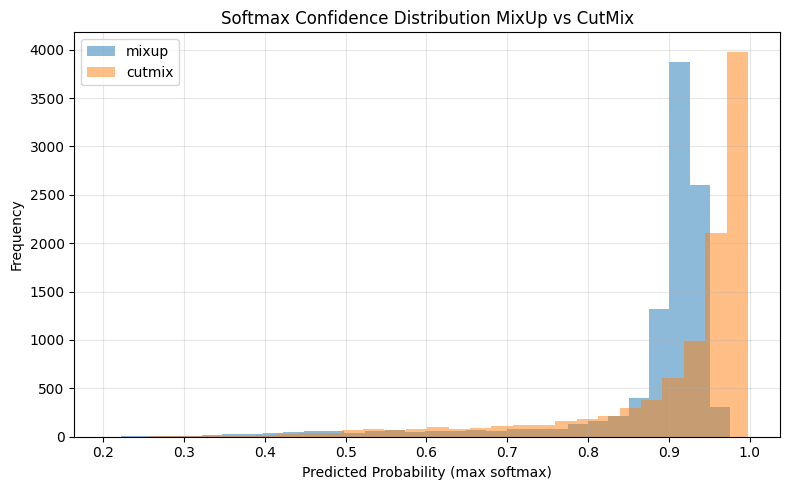


Saved summary to: results/summary.csv
Saved per-run table to: results/final_accs.csv


,run,final_acc,tag
0,results/mixup,0.9447,mixup
1,results/cutmix,0.9476,cutmix


In [ ]:
summarize(["results/mixup", "results/cutmix"], model_name="resnet18_cifar", out_dir="results")


In [ ]:
#CSV table
import pandas as pd, os

mixup_df = pd.read_csv("results/mixup/metrics.csv")
cutmix_df = pd.read_csv("results/cutmix/metrics.csv")

mixup_df["tag"] = "mixup"
cutmix_df["tag"] = "cutmix"

combined = pd.concat([mixup_df, cutmix_df], ignore_index=True)
combined.to_csv("results/all_metrics.csv", index=False)



In [ ]:
from google.colab import files
files.download("results/all_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>